In [24]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import math
import os, time, json


In [25]:
class LSTMRegressor(torch.nn.Module):
    def __init__(self, n_features, hidden_size=128, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = torch.nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.fc = torch.nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last)


In [26]:
def load_checkpoint(path, device="cpu"):
    ckpt = torch.load(path, map_location=device)
    model = LSTMRegressor(
        n_features=len(ckpt["feature_cols"]),
        hidden_size=ckpt["config"]["hidden_size"],
        num_layers=ckpt["config"]["num_layers"],
        dropout=ckpt["config"]["dropout"]
    ).to(device)
    model.load_state_dict(ckpt["model_state_dict"])
    model.eval()
    return model, ckpt["config"], ckpt["feature_cols"], ckpt["target_col"], ckpt["scaler_X"], ckpt["scaler_y"], ckpt.get("symbol", "UNKNOWN")


In [27]:
DEVICE = torch.device("cpu")
btc_model_path = "/Users/dophi/Desktop/btl_doan2/crypto-prediction/models/BTCUSDT_1d_lstm_seq90_h64_L2_do0.1_bs32_20251109_211216.pt"

model, cfg, feat_cols, tgt_col, scaler_X, scaler_y, sym = load_checkpoint(btc_model_path, device=DEVICE)
print(f"✅ Loaded model for {sym}, seq_len={cfg['seq_len']}")


✅ Loaded model for BTCUSDT, seq_len=90


/var/folders/gr/z9d7wnzn4vdf3wzjzl581vlc0000gp/T/ipykernel_41203/2924238718.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location=device)


In [28]:
PATH_BTC = "/Users/dophi/Desktop/btl_doan2/crypto-prediction/data/processed/BTCUSDT_1d_features.csv"   # hoặc đường dẫn gốc của bạn
df = pd.read_csv(PATH_BTC)
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime").reset_index(drop=True)

seq_len = cfg["seq_len"]

# Transform dữ liệu bằng scaler cũ (đã lưu)
X = scaler_X.transform(df[feat_cols].values)
y = scaler_y.transform(df[[tgt_col]].values)


In [29]:
def make_sequences(X, y, seq_len: int):
    Xs, ys = [], []
    for i in range(seq_len, len(X)):
        Xs.append(X[i-seq_len:i])
        ys.append(y[i])
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32)

X_seq, y_seq = make_sequences(X, y, seq_len)

test_loader = DataLoader(
    TensorDataset(torch.tensor(X_seq), torch.tensor(y_seq)),
    batch_size=64, shuffle=False
)

In [30]:
preds, trues = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        out = model(xb.to(DEVICE))
        y_pred = scaler_y.inverse_transform(out.cpu().numpy())
        y_true = scaler_y.inverse_transform(yb.cpu().numpy())
        preds.append(y_pred)
        trues.append(y_true)

y_pred = np.vstack(preds).squeeze()
y_true = np.vstack(trues).squeeze()

BTC Predict - MAE: 1690.91, RMSE%: 3.29%, R²: 0.9950


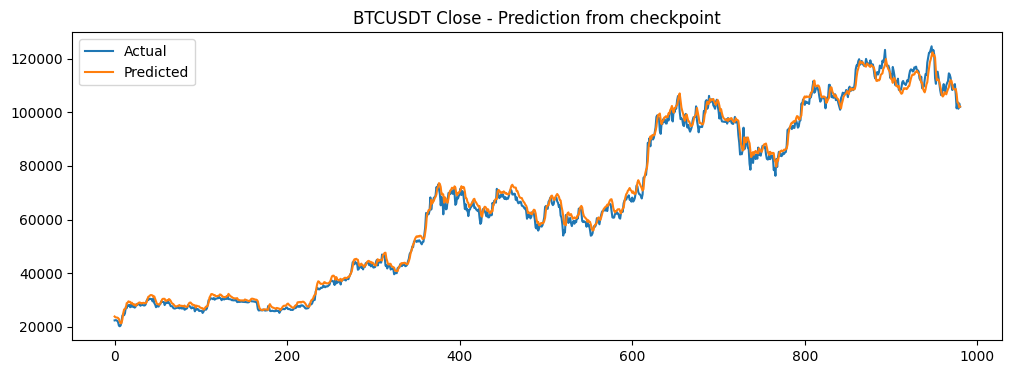

In [31]:
mae = mean_absolute_error(y_true, y_pred)
rmse = math.sqrt(mean_squared_error(y_true, y_pred))
rmse_pct = 100.0 * rmse / np.mean(y_true)
r2 = r2_score(y_true, y_pred)
print(f"BTC Predict - MAE: {mae:.2f}, RMSE%: {rmse_pct:.2f}%, R²: {r2:.4f}")

plt.figure(figsize=(12,4))
plt.plot(y_true, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title(f"{sym} Close - Prediction from checkpoint")
plt.legend()
plt.show()
